# Analyse Twitter Sentiment Trends Prototype [COVID-19 Edition]


In this tutorial we are going to prototype a Twitter sentiment analysis application. This prototype has the following goals:

*   Learn if there are enought tweets for our search request (Tweets per day for a certain topic in a certain region)
*   Learn if these tweets show any positive or negative sentiment variance

In this notebook we will try to explore the following research question:

***Example for this tutorial***

*Can we observe a significant change in user sentiment for COVID-19 related tweets near Munich in the time between 01 March 2020 - 24 April 2020? The following events happend in this time:*

- *Lockdown for Bavaria: 20 March 2020*
- *Nation-wide contact restrictions: 22 March 2020*
- *Cancellation of large events until August 2020: 16 April 2020*
- *Cancellation of Oktoberfest: 21 April 2020*

**Principles:**

1.   We want to **reduce the time and effort** to build the prototype as much as possible.

2.   We will use commodity functions or packages as much as possible for the prototype - **avoid implementations from scratch**

3.   For the sentiment analysis we  want to use a **high quality sentiment model** which was trained on a broad text corpus, in order to get a high quality sentiment analysis out of the box.

For this tutorial, we are using [RAPYD.AI](https://www.rapyd.ai) to access the text mining service.

To use RAPYD.AI, [sign up here for free](https://www.rapyd.ai/free-trial/). 

## Step 1: Prepare Environment
Install and load packages and utility functions

In [0]:
!git clone https://github.com/rapyd-ai/use-cases.git
!pip install GetOldTweets3
!pip install tweet-preprocessor

In [0]:
import pandas as pd
import GetOldTweets3 as got
import preprocessor as p
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append('use-cases/classify-user-reviews/utils')
from rapyd_ai_utils import *


## Step 2: Load tweets for a given date range and location

For our analysis, we want to get tweets for  

*   a specific search team
*   in a given date range
*   tweeted near a given location

We can customize the Twitter query even more. See [this documentation]('https://pypi.org/project/GetOldTweets3/) for details

The location has to be entered with latitute and longitute coordniates. Visit [this website](https://www.latlong.net/) to find the lat and long for custom location.


In [0]:
# Enter your custom values here
# Example: Munich
SEARCH = "covid-19"
LATITUDE = "48.14"
LONGITUDE = "11.58"
RADIUS = "15mi"
START_DATE = "2020-03-01"
END_DATE = "2020-04-24"

In [0]:
tweetCriteria = got.manager.TweetCriteria().setQuerySearch(SEARCH)\
                                           .setSince(START_DATE)\
                                           .setUntil(END_DATE)\
                                           .setNear(LATITUDE + ", " + LONGITUDE)\
                                           .setWithin(RADIUS)\
                                           .setMaxTweets(5000)
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

How many tweets did we fetch?

---



In [5]:
len(tweets)

3212

## Step 3: Preprocess Twitter data

Convert tweets to Pandas DataFrame for data wrangling.

In [7]:
df = pd.DataFrame([vars(s) for s in tweets])
df.head(5)

,username,to,text,retweets,favorites,replies,id,permalink,author_id,date,formatted_date,hashtags,mentions,geo,urls
0,News__Poster,None,"Coronavirus: Aufnahmen zeigen, was Covid-19 in...",0,0,0,1253470575579848708,https://twitter.com/News__Poster/status/125347...,77838776,2020-04-23 23:47:28+00:00,Thu Apr 23 23:47:28 +0000 2020,,,,https://is.gd/1aCFeC
1,AlexRuebben,None,Hopefully results will come soon: Repositioned...,2,2,1,1253464950653235202,https://twitter.com/AlexRuebben/status/1253464...,37893536,2020-04-23 23:25:07+00:00,Thu Apr 23 23:25:07 +0000 2020,,,,https://www.medrxiv.org/content/10.1101/2020.0...
2,ChrisBrey1,None,'What's wrong with you Mexico?' Health workers...,0,0,0,1253464004787408896,https://twitter.com/ChrisBrey1/status/12534640...,787774580,2020-04-23 23:21:21+00:00,Thu Apr 23 23:21:21 +0000 2020,,,,https://www.theguardian.com/world/2020/apr/23/...
3,News__Poster,None,Elizabeth Warren: US-Politikerin trauert um ve...,0,0,0,1253462924464730112,https://twitter.com/News__Poster/status/125346...,77838776,2020-04-23 23:17:04+00:00,Thu Apr 23 23:17:04 +0000 2020,,,,https://is.gd/ZHyzSD
4,Severyn55,None,"Trump: ""it was illegal!"" https://youtu.be/5VXd...",0,1,0,1253459112773455874,https://twitter.com/Severyn55/status/125345911...,52056547,2020-04-23 23:01:55+00:00,Thu Apr 23 23:01:55 +0000 2020,#wwg1wga #covid19 #wwg1wgaworldwide,@YouTube,,https://youtu.be/5VXdiYAu2tU


Tweet text processing - Delete URLs and mentions from text for better sentiment analysis.

In [0]:
p.set_options(p.OPT.URL, p.OPT.MENTION) # delete URLs, Mentions 
df['text_clean'] = df['text'].apply(lambda x: p.clean(x))

### Set Prototyping Constraints

Depending on our search query we might get a lot of tweets back. However, for our prototyping purpose it is not necessary to analyse the sentiment of all of them. After all, we first want to get a general idea of what's going on on twitter.

To limit the requests to the AI-as-a-Service there are different approached.

Our approach here is to filter out tweets below a certain relevance threshold, defined by the times they were retweeted or favorited.

The threshold we choose depends on the amount of data that we want to analyse.

In our case, we want to limit the API calls to 500 tweets.

In [0]:
df = df.query("retweets > 5 |  favorites > 5")

In [18]:
len(df)

574

## Step 4: Explore Tweets After Preprocessing

We want to find out if we still have enought tweets per day. What "enough" is depends on your use case, but ca. 10 tweets per day should be considered the asbsolute minimum.

In [0]:
# Date-Time to Date
df['week'] = df['date'].dt.week
df['date'] = df['date'].dt.date

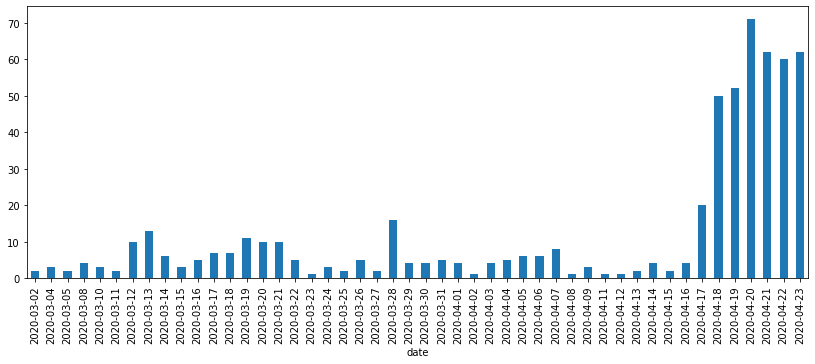

In [20]:
df['date'].groupby(df['date']).count().plot(kind = 'bar', rot = 90, figsize=(14,5))

## Step 5: Get Sentiments for Tweets

Now we are ready to call the AI-service to analyse the tweets sentiment for us. If you don't have an Account ID and Token yet, you can [sign up here for free](https://www.rapyd.ai/free-trial/). 

In [0]:
ACCOUNT_ID = 'your-account-id>' 
TOKEN = 'your-token'

In [27]:
sentiment_scores = df['text_clean'].apply(lambda x: get_sentiment_score(x, "GCP", "AUTO", ACCOUNT_ID, TOKEN))

Genom att dela med mig av min träning i vardagen så hoppas jag kunna inspirera andra! #covid_19 #strongertogether #stayhome #stayhealthy #olympians #tillsammans io.grpc.StatusRuntimeException: INVALID_ARGUMENT: The language sv is not supported for document_sentiment analysis.
Czy jesteśmy gotowi na pandemię wirusa? Nie. Żaden kraj nie jest. Zaskoczyło nas wszystko liczba chorych, którzy muszą być podłączeni do respiratorów,i tych, którzy Covid-19 przechodzą bezobjawowo, a mimo to mogą zakażać. Zaskoczyła nas przymusowa izolacja,obowiązkowe maseczki. io.grpc.StatusRuntimeException: INVALID_ARGUMENT: The language pl is not supported for document_sentiment analysis.
#Optimismus #Corona #COVID19 #CoronaVirusDE #MaskeAuf io.grpc.StatusRuntimeException: INVALID_ARGUMENT: The language ca is not supported for document_sentiment analysis.
Yang kita lakukan sekarang adalah mendukung setiap program dari pemerintah agar kita terhindar dari Covid-19 ini.sekiranya tidak perlu menyalahkan pemerintah 

Some tweets likely could not be properly analysed - mainly proably because the language was not recognized or is not supported. We will drop these values in our postprocessing.

Each tweet sentiment will be indicated by a score between 0 and 1 for both positive and negative sentiment.

Example: 'negative': 0.7 can be interpreted as "this tweet is 70% likely to have a positive sentiment". Depending on the AI service you are using, positive and negative sum up to 1, or they leave a rest, which is denoted as "neutral" sentiment"

### Sentiment Postprocessing

In [0]:
sentiment_df = pd.DataFrame.from_dict(list(sentiment_scores))
sentiment_df = pd.concat([df.reset_index(drop = True), sentiment_df.reset_index(drop = True)], axis = 1)
sentiment_df = sentiment_df.dropna(subset=['positive', 'negative'])
sentiment_df.to_csv("sentiment_df.csv") # It's good practice to persist the sentiment scores locally so they can be re-loaded again, if needed.
sentiment_df = sentiment_df[['text_clean', "retweets", "date", "hashtags", "negative"]]

## Step 6: Analyse

### Analyse Overall Sentiment

First, let's have a look at how the sentiment polarity is distributed across our tweets. Before we look at the distribution we will copy each tweet as many times as it got retweeted. Why? Imagine the following scenario:

*   Tweet 1: Negative sentiment = 0.1, retweets = 0
*   Tweet 2: Negative sentiment = 0.9, retweets = 1.000

What to you think would be the better average sentiment score? 0.5 or 0.89?

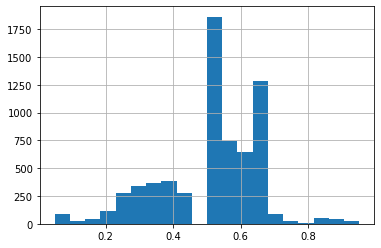

In [29]:
sentiment_df = sentiment_df.loc[sentiment_df.index.repeat(sentiment_df.retweets)].reset_index(drop=True) # Copy Retweets
sentiment_df['negative'].hist(bins = 20)

### Analyse Sentiment Trend Over Time

In order to analyse the sentiment trend over time, we will calculate the sentiment mean and standard deviation (to find out how much the data spreads around the mean) for each day. Next, we will plot this data.

This graph shows the average daily sentiment scores over time. The vertical bars shows the standard deviation for each day, indicating how much variance is in the data. 

Beware: Days with less tweets will have higher standard deviation. If you have only one or two tweets per day, the standard devation can't be properly calculated. That's why it's good to have at least ca. 10 tweets per day, as a rule of thumb.

To remind us about the absolute number of tweets for each day, we will plot this graph right below.

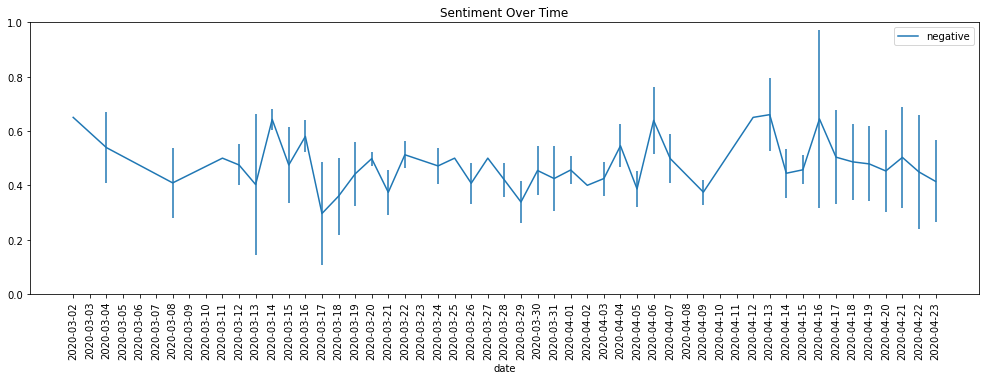

In [30]:
daily_sentiment_mean = sentiment_df[['date', 'negative']].groupby('date').mean()
daily_sentiment_errors = sentiment_df[['date', 'negative']].groupby('date').std()

#X Axis
x_axis = pd.date_range(sentiment_df['date'].min(), sentiment_df['date'].max()).to_list()
daily_sentiment_mean.plot(rot = 90, figsize=(17,5), ylim = (0,1), xticks = x_axis, yerr = daily_sentiment_errors, title = "Sentiment Over Time")

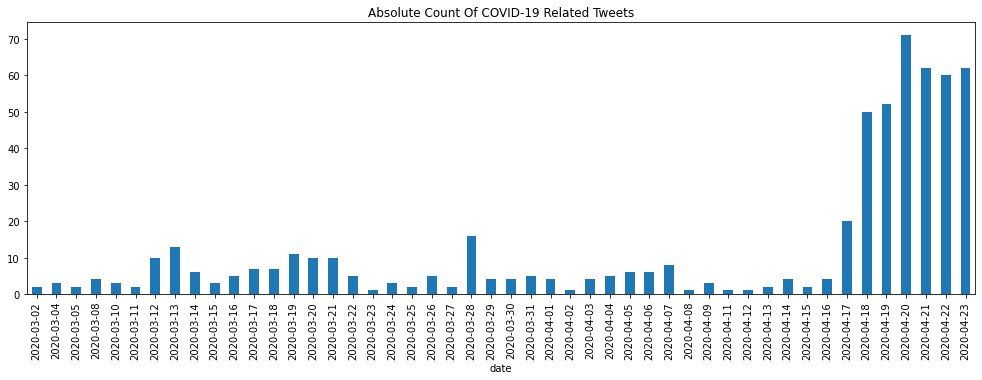

In [31]:
df['date'].groupby(df['date']).count().plot(kind = 'bar', rot = 90, figsize=(17,5), title = "Absolute Count Of COVID-19 Related Tweets")

### Analyse Popular Hashtags per Day

Now that we hopefully found some spikes or drops in our sentiment data, we consequently want to know the "hot topics" during these days. We will approximate them by looking at popular hash tags during a given day.

Look at the popular hashtags for a specific date.

In [0]:
# Calculate popular hashtags
popular_hashtags = sentiment_df[['hashtags', 'negative', 'date']].groupby("date").agg({'hashtags': ' '.join})
popular_hashtags['hashtags'] = popular_hashtags['hashtags'].apply(hashtag_frequency)
popular_hashtags['hashtags'] = popular_hashtags['hashtags'].apply(lambda x: pd.DataFrame(x, columns= ['Hashtag', 'Count']).sort_values('Count', ascending = False))

In [46]:
day = "2020-04-21"
from datetime import datetime
day = datetime.strptime(day, '%Y-%m-%d').date()

popular_hashtags.query('date == @day')['hashtags'][0].head(10)

,Hashtag,Count
89,#health,85
69,#VR,80
70,#AR,80
68,#video,80
60,#Monaco,61
22,#directCN,54
101,#Oktoberfest,51
75,#M,34
72,#Ausgangssperre,30
71,#Atemschutzmaske,30


## Step 7: Conclusion

***Example Conclusion:*** *Tweets started to grow after April 17. Before that, it is difficult to analyse daily sentiment due to a lack of data. The overall negative sentiment trend after April 17 seems to be slightly decreasing. April 21 showed a slight increase in negative sentiment.*

*Oktoberfest can be found in popular hashtags, probaly due to the cancellation announcement. Lockdown ("Ausgangssperre") and masks ("Atemschutzmaske") were also popular.*

## Next Steps

Using the Sentiment Trend, Daily Tweet Counts and Popular Hashtags graphs you can quickly assess if it makes sense to drive the analysis further.

If you don't find any meaningful insights yet, you might consider changing your search - either by getting more data or maybe changing the search term.

If you found something that you find worth exploring further, try to analyse more data using the AI-as-a-service or train a custom model to predict the sentiment more accuratley. 

In any case, this is not the end of your analysis, but just the end of your first iteration phase of your prototype :-)

Happy analyzing!